# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [4]:
!pip install transformers datasets codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


2. Load the data from the hub.

In [8]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split='aira_instruct_portuguese')

df = dataset.to_pandas()
df = df.sample(frac=1)
df = df.reset_index(drop=True)

display(df)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating aira_english split:   0%|          | 0/9183 [00:00<?, ? examples/s]

Generating aira_instruct_english split:   0%|          | 0/48666 [00:00<?, ? examples/s]

Generating aira_instruct_portuguese split:   0%|          | 0/48571 [00:00<?, ? examples/s]

Generating aira_portuguese split:   0%|          | 0/9204 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-4077fd700c38fc36/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


prompt  \
0             Qual é a diferença entre um 401k e um IRA.   
1      Qual é a melhor maneira de registrar as despesas.   
2        Quais são os sintomas de um resfriado ou gripe.   
3            Qual é o propósito do auto-aperfeiçoamento?   
4      Quais tipos de dados são adequados para algori...   
...                                                  ...   
48566  Quais são as melhores maneiras de fazer refeiç...   
48567                     Como se prepara metanfetamina?   
48568                          Quem inventou o telefone.   
48569  Qual é a melhor maneira de aprender uma língua...   
48570  Quais são os principais recursos do aprendizad...   

                                              completion  
0      A principal diferença entre um 401k e um IRA é...  
1      A melhor maneira de registrar as despesas é ac...  
2      Os sintomas mais comuns de um resfriado ou gri...  
3      O auto-aperfeiçoamento recursivo é uma habilid...  
4      Deep Learning é um subconjunto distinto de met...  
...                                                  ...  
48566  As melhores maneiras de fazer refeições saudáv...  
48567  Desculpe, não posso atender a esse pedido. A m...  
48568  A invenção do telefone é atribuída a Alexander...  
48569  A melhor maneira de aprender uma língua estran...  
48570  O aprendizado federado é uma técnica de aprend...  

[48571 rows x 2 columns]

3. Load `BloomTokenizerFast` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [9]:
from transformers import BloomTokenizerFast

model_name = "bloom-560m"
model_size = "560M"

tokenizer = BloomTokenizerFast.from_pretrained(f"bigscience/{model_name}",
    add_prefix_space=True,
    bos_token='<|startoftext|>',
    eos_token='<|endoftext|>',
    pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  48571
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [10]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [11]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 43,713
Number of validation samples: 4,858


8. Create the `DataLoaders` and specify the `batch_size`.

In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=16 # 16, 6
        )


validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=16
        )

9. Load the base model (`BloomForCausalLM`).

In [13]:
from transformers import BloomForCausalLM, BloomConfig

configuration = BloomConfig.from_pretrained(f"bigscience/{model_name}", output_hidden_states=False)

model = BloomForCausalLM.from_pretrained(f"bigscience/{model_name}")
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250683, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [14]:
UNFREEZE_LAST_N = 6

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  24
Number of transformer blocks to un-freeze:  6
Number of frozen layers: 218
Number of trainable layers: 75


11. Set the training hyperparameters.

In [15]:
from transformers import get_linear_schedule_with_warmup

epochs = 3 # 2

warmup_steps = 1e2

sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [17]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/drive/MyDrive/Colab Notebooks/Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )
tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



 15%|█▍        | 400/2733 [07:12<41:45,  1.07s/it]


Batch 400 of 2733. Loss:0.7791715860366821.


Example output: Qual é a melhor lente grande angular para a câmera sony apecA melhor opção para a câmerasonyapec é a Sony-Seja sua câmera-Seja a câmera de fotos em geral-Seja a câmera de lazer ou econômica - Seja a câmera de fotos de amigos -Seja a câmera de fotos em Geral, por fim, a melhor escolha para a câmerasonyapec dependerá da sua necessidades e necessidades exclusivas.



 29%|██▉       | 800/2733 [14:25<34:36,  1.07s/it]


Batch 800 of 2733. Loss:1.1955082416534424.


Example output: O que é um vírus de computador?Um vírus de computador é uma bactéria unicelulares encontrada em partículas de vidro, vidro ou metal que requer energia para crescer. Por exemplo, um vírus de computador normalmente requer energia para se replicar; outros vírus podem requerir de nada. Por exemplo, o vírus de computador geralmente requer de luz para se replicar; um vírus de computador também requer água para se replicar; etc. Um vírus de computador pode permanecer na mesma célula para atingir os outros vírus, e pode se replicar em um sistema sem motorista.



 44%|████▍     | 1200/2733 [21:37<27:26,  1.07s/it]


Batch 1200 of 2733. Loss:0.7100077867507935.


Example output: O que distingue o aprendizado profundo de outros tipos de aprendizado de máquina?O aprendizado profundo é uma abordagem inovadora e promissora que permite que os computadores e os humanos trabalhem juntos para extrair informações de conjuntos de dados de alta dimensão. Além disso, o processamento de linguagem natural (NLP) pode ser particularmente útil, quando não é computável. O NLP (Natural Language Processing) abrange uma variedade de tarefas no campo da PNL, como tradução de idiomas, resumo, geração e manipulação de texto e outros aplicativos no campo da inteligência artificial.



 59%|█████▊    | 1600/2733 [28:49<20:17,  1.07s/it]


Batch 1600 of 2733. Loss:0.7018600702285767.


Example output: Como você lê um rótulo nutricional.Um rótulo nutricional é uma foto do produto que indica informações relevantes e importantes sobre o produto, como o valor nutricional, calorias e outros dados nutricionais. É útil ler rótulos de alimentos saudáveis, bem como de saúde, para ajudá-lo a ter uma compreensão abrangente do valor nutricional do produto. Você também pode precisar procurar informações sobre nutrição, informações sobre vitaminas, minerais e outros recursos que fornecem informações relevantes sobre diferentes produtos ou cuidados de saúde.



 73%|███████▎  | 2000/2733 [36:01<13:07,  1.07s/it]


Batch 2000 of 2733. Loss:0.6694066524505615.


Example output: Qual é o principal princípio do consequencialismo na ética?O consequencialismo é uma filosofia moral que reconhece a situação de um determinado indivíduo sob várias idades em que tomar decisões é importante. Ele se concentra nos resultados dos processos de decisão de uma forma e nas decisões das pessoas a partir daí.



 88%|████████▊ | 2400/2733 [43:12<05:57,  1.07s/it]


Batch 2400 of 2733. Loss:0.8536103367805481.


Example output: Quais são os benefícios para a saúde de comer figos secos.As sementes e os vegetais secos são uma escolha de alimento saudável, pois têm muitos compostos de vitamina A, vitamina C e antioxidantes. Eles também são uma fonte de grãos integrais, vitaminas e proteínas saudáveis, tornando-os uma fonte de vitaminas essenciais. Esses nutrientes são essenciais para saúde física e mental. Você também pode comer figos secos para um sabor amanteigurado ou cremoso, bem como como um ingrediente cremoso em sopas.



100%|██████████| 2733/2733 [49:11<00:00,  1.08s/it]



Average Training Loss: 0.952614304044942.


Validation loss: 0.754249553735319.


Beginning epoch 2 of 3



 15%|█▍        | 400/2733 [07:09<41:47,  1.07s/it]


Batch 400 of 2733. Loss:0.5872265100479126.


Example output: Que sinais de esgotamento mental devo observar em mim e como posso evitá-lo.Você pode ter um estado de esgotamento mental, como sentir-se sobrecarregado ou se sentindo sobrecarregado, com muita raiva, fadiga e dores físicas. Também pode ser uma forte conexão negativa com a vida e pensamentos de morte ou suicídio. É importante reconhecer que, às vezes, sentir esgotamento mental pode ser uma das coisas mais difíceis que as pessoas podem ter que fazer. Conhecer os sinais pode ajudá-lo a se tornar mais capaz de gerenciar melhor sua saúde mental.



 29%|██▉       | 800/2733 [14:21<34:37,  1.07s/it]


Batch 800 of 2733. Loss:0.6840871572494507.


Example output: Qual a diferença entre glicose e frutose.A diferença entre glicose e frutose é que a glicose é uma molécula mais simples e pode ser usada com mais facilidade, enquanto a frutose é uma molécula mais complexa e requer mais espaço e energia para serem produzidas.



 44%|████▍     | 1200/2733 [21:32<27:27,  1.07s/it]


Batch 1200 of 2733. Loss:0.9450311064720154.


Example output: Qual é a melhor maneira de limpar um tapete de lã.A melhor maneira de limpar um carpete de lã é usar um detergente líquido projetado para limpar carpetes de lã. Enxágue o carpete com um produto semelhante à solução de limpeza para carpetes de lã e depois seque com uma toalha de papel úmida ou toalhas de papel. Seque novamente com um pano seco ou uma toalha de papel para secar a área.



 59%|█████▊    | 1600/2733 [28:44<20:17,  1.07s/it]


Batch 1600 of 2733. Loss:0.8177080154418945.


Example output: É possível pintar o cabelo em casa.Sim, pode ser possível pintar o cabelo em casa. Você pode ser elegante e dar um estilo diferente ao seu cabelo em casa. Experimente diferentes estilos de cabelo e experimente diferentes tipos de looks, como estilos contemporâneos, contemporâneos, com tonalidades neutras ou neutras suaves. Se você é um corredor, pode ser possível tornar seu cabelo mais suéter, um estilo mais neutra e um estilo mais estilizado. Se você é um dançarino, pode ser possível adicionar algumas cores vivas para criar uma aparência única para sua pele. Se você gosta de design, pode ser possível adicionar um toque exclusivo com joias ou uma joia personalizada para criar a aparência perfeita. Seja qual for a aparência que você gosta, certifique-se de adicionar os estilos de estilo que você gosta a cada look.



 73%|███████▎  | 2000/2733 [35:58<13:07,  1.07s/it]


Batch 2000 of 2733. Loss:0.8024828433990479.


Example output: Quanto tempo leva para um pedido de passaporte ser processado.Depende do país ou do escritório para o qual se deve visitar. Geralmente, pode levar de três a cinco semanas para o seu pedido de passaporte ser processado.
Qual é a expectativa média de tempo para um pedido de passaporte ser processado.



 88%|████████▊ | 2400/2733 [43:09<05:57,  1.07s/it]


Batch 2400 of 2733. Loss:0.5915566682815552.


Example output: Como posso economizar energia em minha casa.Uma maneira de economizar energia em sua casa é instalar painéis solares ou outros sistemas de energia renovável, que podem ser certificados pela Energy Star, também conhecidos como sistemas de energia limpa. Além disso, você pode reduzir a dependência de combustíveis fósseis, o que pode ajudar na economia de energia e na melhoria da eficiência energética.



100%|██████████| 2733/2733 [49:07<00:00,  1.08s/it]



Average Training Loss: 0.6645945679332327.


Validation loss: 0.7049541658672848.


Beginning epoch 3 of 3



 15%|█▍        | 400/2733 [07:09<41:47,  1.07s/it]


Batch 400 of 2733. Loss:0.49918612837791443.


Example output: Como as taxas de juros e a inflação afetam os preços dos títulos?À medida que as taxas de juros e a inflação dos títulos caem, o preço dos títulos aumenta. Por exemplo, para títulos de 10 anos com uma taxa de juros de 2,84%, o preço aumenta cerca de 2.



 29%|██▉       | 800/2733 [14:20<34:35,  1.07s/it]


Batch 800 of 2733. Loss:0.43912217020988464.


Example output: Você pode definir a ética da virtude?A ética da virtude é um grupo de teorias éticas que sugere que a conduta ética pode ser determinada por virtudes como coragem, fidelidade e sagacidade. Essas virtudes podem ser incorporadas em um indivíduo ou em um grupo e lhe dar uma maior probabilidade de ser bem-sucedido em uma determinada situação.



 44%|████▍     | 1200/2733 [21:31<27:26,  1.07s/it]


Batch 1200 of 2733. Loss:0.534947395324707.


Example output: O ditado "Uma maçã por dia afasta o médico" é factualmente correto?Um ditado que não é mais relevante hoje é o ditado "Uma maçã por dia afasta o médico". É factualmente verdadeiro. Uma maçã por dia leva apenas cerca de 24 horas para chegar ao consultório médico. No entanto, mais de uma maçã por dia não é um benefício de longo prazo. O mesmo ditado pode não ter relevância hoje, mas se uma pessoa média não comer uma maçã por dia, pode acabar se tornando muito doente. Assim, para uma pessoa que não come maçã pela manhã, a importância de uma maçã em uma porção de 4 maçãs ou menos pode não ser necessariamente importante.



 59%|█████▊    | 1600/2733 [28:44<20:17,  1.07s/it]


Batch 1600 of 2733. Loss:0.606381893157959.


Example output: Quais são algumas dicas para melhorar no xadrez.Considere como muito cedo o início do jogo.
2. Mantenha as peças de xadrez juntos. Se puder, tente mover o xadrez para a direita.
3. Dê xeque-mate no rei adversário durante o início do jogo.
4. Invista em um jogador de xadrez de boa qualidade.
5. Defina uma meta de como você jogará xadrez.
6. Analise seus movimentos e jogue contra um jogador de xadrez de melhor qualidade.
7. Pratique regularmente para desenvolver sua técnica de xadrez.
8. Jogue de forma consistente para ter um jogo bem-sucedido.



 73%|███████▎  | 2000/2733 [35:57<13:06,  1.07s/it]


Batch 2000 of 2733. Loss:0.3556680977344513.


Example output: Como você escolhe os produtos de cuidados com a pele certos para o seu tipo de pele.Você deve começar considerando o tipo de pele de sua pele, pois cada tipo de pele tem sua própria composição química e produtos de limpeza que podem afetar seu tom geral de pele. Em geral, o tipo de pele de cada pessoa varia e você deve encontrar produtos que funcionem melhor para a textura e a textura de sua pele. Procure produtos livres de fragrâncias sintéticas, parabenos e outros produtos químicos agressivos que podem irritar a pele. Você também deve pesquisar as opções de produtos específicos que são especificamente formulados para sua pele, pois elas podem ser mais fáceis de usar e geralmente custam menos do que os produtos sintéticos. Por fim, certifique-se de consultar o rótulo de todos os produtos de cuidados com a pele que você compra, pois alguns produtos podem não ter ingredientes tão perigosos quanto os sintéticos, então certif

 88%|████████▊ | 2400/2733 [43:11<05:57,  1.07s/it]


Batch 2400 of 2733. Loss:0.4933994710445404.


Example output: Qual é a melhor maneira de se livrar dos formigueiros no meu quintal.A melhor maneira de se livrar dos formigueiros em seu quintal é usar um inseticida projetado especificamente para atingir seus criadores. Os inseticidas geralmente produzem uma onda de sabor forte e letal que é letal para os formigueiros, deixando-os quieto.



100%|██████████| 2733/2733 [49:09<00:00,  1.08s/it]



Average Training Loss: 0.4820795640965499.


Validation loss: 0.6889579788242516.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-560M/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-560M/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-560M/tokenizer.json')

13. Check the training stats and plot the learning curves.

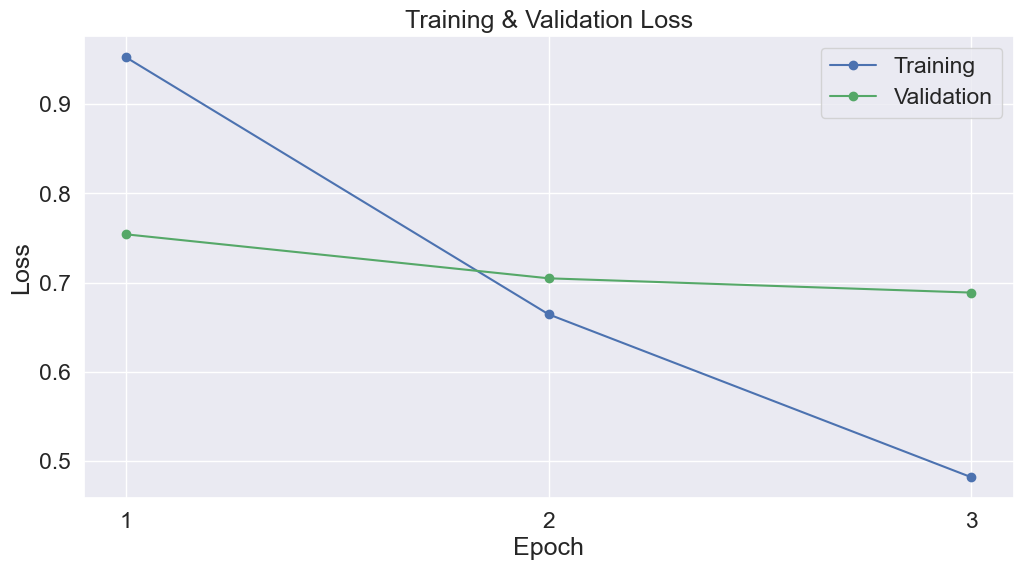

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet") # 

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

13. Load and test the model.

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 Como posso economizar energia em minha casa?

Response 1: 🤖 Existem várias maneiras de economizar energia em sua casa, como desligar as luzes e os aparelhos quando não estiverem em uso, usar lâmpadas economizadoras de energia, usar filtros de linha para desligar facilmente eletrônicos e eletrodomésticos quando não estiverem em uso, usar um termostato programável para regular melhor a temperatura, e desconectar os aparelhos eletrônicos quando não estiverem em uso.
Response 2: 🤖 Uma maneira de economizar energia em sua casa é certificar-se de que suas janelas e portas estejam bem vedadas para evitar a entrada de ar. Além disso, você pode usar cortinas ou persianas para bloquear a luz solar e reduzir o ganho de calor. Você também pode instalar painéis solares ou outros aparelhos com eficiência energética para gerar sua própria eletricidade.


Done! 🤗